# Importing Libraries

In [6]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.applications import VGG19,ResNet50
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import time
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder


In [2]:
DEVICE = "TPU" #or "GPU"

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.MirroredStrategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  2
REPLICAS: 2


# Preparing data for training

In [3]:
#create labels
classes=[]
filename='../input/brain-tumor-classification-mri'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']


In [5]:
X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
#         print(img.shape)
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train) 

100%|██████████| 100/100 [00:00<00:00, 126.33it/s]


In [ ]:
# X_train = X_train/255.0

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=15, #rotate images
    width_shift_range=0.1,
    height_shift_range=0.1, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True,
    rescale = 1.0/255.0
    )

datagen2 = ImageDataGenerator(
            rescale=1.0/255.0
            )

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

# lb = LabelEncoder()
# labels_train=lb.fit(y_train)
# y_train=lb.transform(y_train)
# y_test=lb.transform(y_test)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the labels to one-hot encoding
y_train = encoder.fit_transform(y_train.reshape(-1,1))
y_test = encoder.transform(y_test.reshape(-1,1))


# train_generator = datagen.flow(X_train, y_train, batch_size=16)
# test_generator = datagen2.flow(X_test,y_test,batch_size=1)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Analyzing Data

In [ ]:
category_mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))

print(category_mapping)

In [11]:
y_train

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [12]:
print("Train")
c0=0;c1=0;c2=0;c3=0
for i in y_train:
    if i[0]==1: c0+=1
    if i[1]==1: c1+=1
    if i[2]==1: c2+=1
    if i[3]==1: c3+=1
print("c0",c0,"c1",c1,"c2",c2,"c3",c3)
print("Train")
c0=0;c1=0;c2=0;c3=0
for i in y_test:
    if i[0]==1: c0+=1
    if i[1]==1: c1+=1
    if i[2]==1: c2+=1
    if i[3]==1: c3+=1
print("c0",c0,"c1",c1,"c2",c2,"c3",c3)

Train
c0 787 c1 796 c2 425 c3 766
Train
c0 139 c1 141 c2 75 c3 135


# Callback Function


In [22]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

# Defining models

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def vgg_model(dim):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = VGG19(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    count = 0
    for i in base.layers:
        if "block4" in i.name:
            break
        count+=1
    a = [i.name for i in base.layers][count:]
    base.trainable = True
    set_trainable = False
    for layer in base.layers:
      if layer.name in a:
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=0.55)(x)
    x = tf.keras.layers.Dense(128,activation='elu',kernel_initializer='GlorotNormal')(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
#     x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(4,activation='softmax')(x)
    opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)
    model = tf.keras.Model(inputs=inp,outputs=x)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC()])
    return model

In [34]:
def eff_model(dim=128):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EfficientNetB3(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    count = 0
    for i in base.layers:
        if "block6" in i.name:
            break
        count+=1
    a = [i.name for i in base.layers][count:]
    base.trainable = True
    set_trainable = False
    for layer in base.layers:
      if layer.name in a:
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=0.55)(x)
    x = tf.keras.layers.Dense(64,activation='elu')(x)
#     x = tf.keras.layers.Dense(8,activation='relu')(x)
#     x = tf.keras.layers.Dropout(rate=0.5)(x)
#     x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(4,activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = Adam(
        learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
        epsilon=1e-08)  
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC()])
    return model

In [35]:
def resnet_model(dim=128):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = ResNet50(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    count = 0
    for i in base.layers:
        if "conv5_block3" in i.name:
            break
        count+=1
    a = [i.name for i in base.layers][count:]
    base.trainable = True
    set_trainable = False
    for layer in base.layers:
      if layer.name in a:
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=0.6)(x)
    x = tf.keras.layers.Dense(64,activation='elu',kernel_initializer='GlorotNormal')(x)
#     x = tf.keras.layers.Dropout(rate=0.3)(x)
    x = Dense(64, activation='elu',kernel_initializer='GlorotNormal')(x)
    x = tf.keras.layers.Dense(4,activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = Adam(
        learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
        epsilon=1e-08) 
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC()])
    return model

In [36]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential


# Modified CNN model with increased complexity and regularization
def cnn_model(dim=128):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(dim, dim, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

#     model = Model(inputs=inp, outputs=out)
    
    opt = Adam(
        learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
        epsilon=1e-08)  
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC()])
    return model

# Training and Testing models

In [58]:
Auc.pop(2)
Time.pop(2)

('eff', 151.82944416999817)

In [59]:
print("loss",loss)
print("Auc",Auc)
print("Time",Time)
print("Auc_classes",Auc_classes)

loss [('VGG', 0.19421565532684326), ('eff', 0.2908536493778229), ('Resnet', 0.2692817747592926), ('CNN', 0.6051872372627258)]
Auc [('VGG', 0.9951436025437623), ('eff', 0.9850323000237537), ('Resnet', 0.9883368208319121), ('CNN', 0.9294392676172)]
Time [('VGG', 127.65519309043884), ('eff', 155.91951727867126), ('Resnet', 94.01976561546326), ('CNN', 162.59526252746582)]
Auc_classes [('VGG', [0.992375330504827, 0.9907537239122924, 0.9988433734939759, 0.998601982263954]), ('Effe', [0.9744204636290967, 0.9710622040683615, 0.9955662650602409, 0.9963901930099114]), ('Resnet', [0.9784377626104245, 0.9800443008392773, 0.9979116465863453, 0.9969535732916015]), ('CNN', [0.8849945684478059, 0.8897152959824423, 0.9523534136546186, 0.9906937923839333])]


In [25]:
loss = []
Auc = []
Time = []
Auc_classes = []

Training...
Epoch 1/11
87/87 [==============================] - 18s 137ms/step - loss: 1.5649 - accuracy: 0.4243 - auc: 0.6830 - val_loss: 0.8372 - val_accuracy: 0.6918 - val_auc: 0.8908
Epoch 2/11
87/87 [==============================] - 11s 124ms/step - loss: 0.7939 - accuracy: 0.6907 - auc: 0.8934 - val_loss: 0.5369 - val_accuracy: 0.7939 - val_auc: 0.9526
Epoch 3/11
87/87 [==============================] - 11s 127ms/step - loss: 0.5794 - accuracy: 0.7837 - auc: 0.9427 - val_loss: 0.4528 - val_accuracy: 0.8469 - val_auc: 0.9635
Epoch 4/11
87/87 [==============================] - 11s 126ms/step - loss: 0.4426 - accuracy: 0.8439 - auc: 0.9655 - val_loss: 0.3297 - val_accuracy: 0.8959 - val_auc: 0.9819
Epoch 5/11
87/87 [==============================] - 11s 125ms/step - loss: 0.3134 - accuracy: 0.8875 - auc: 0.9827 - val_loss: 0.3187 - val_accuracy: 0.9041 - val_auc: 0.9815
Epoch 6/11
87/87 [==============================] - 11s 125ms/step - loss: 0.2311 - accuracy: 0.9214 - auc: 0.990

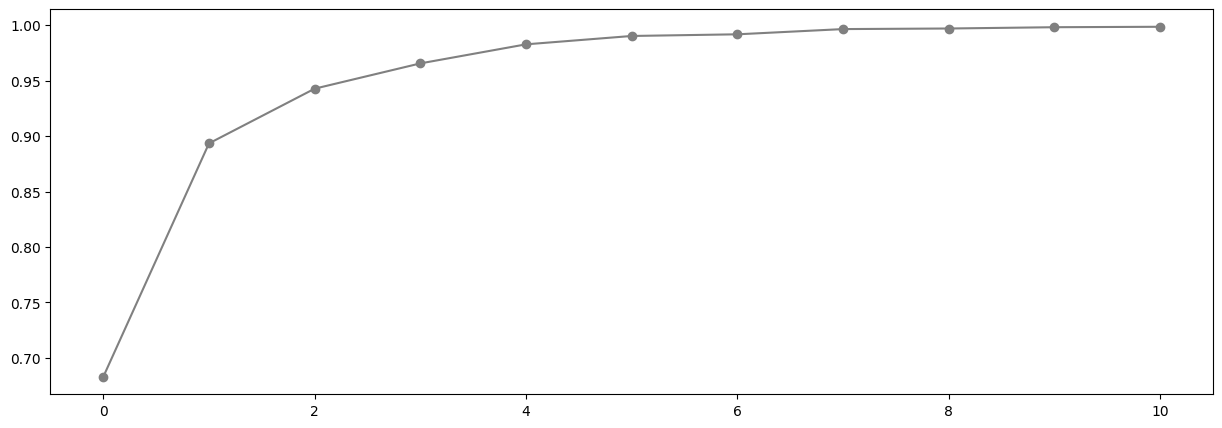

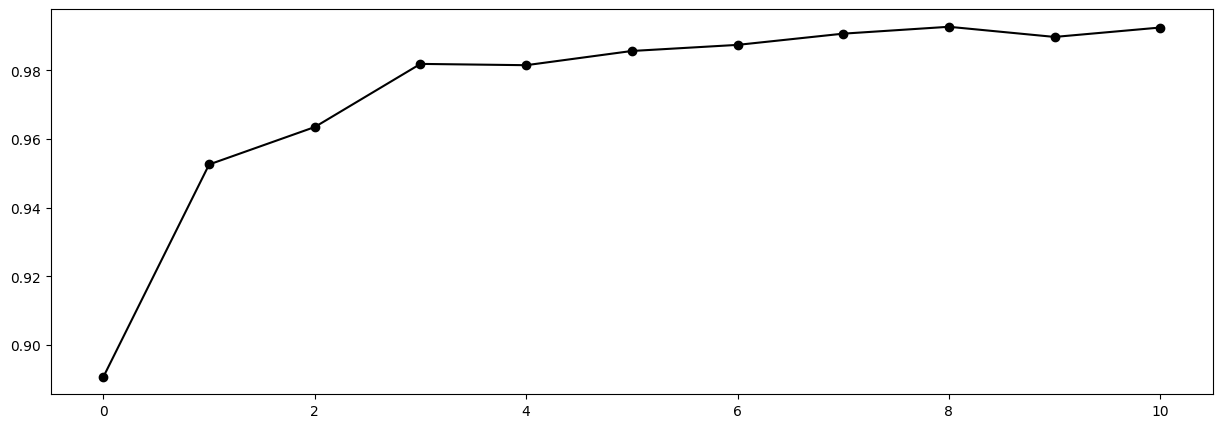

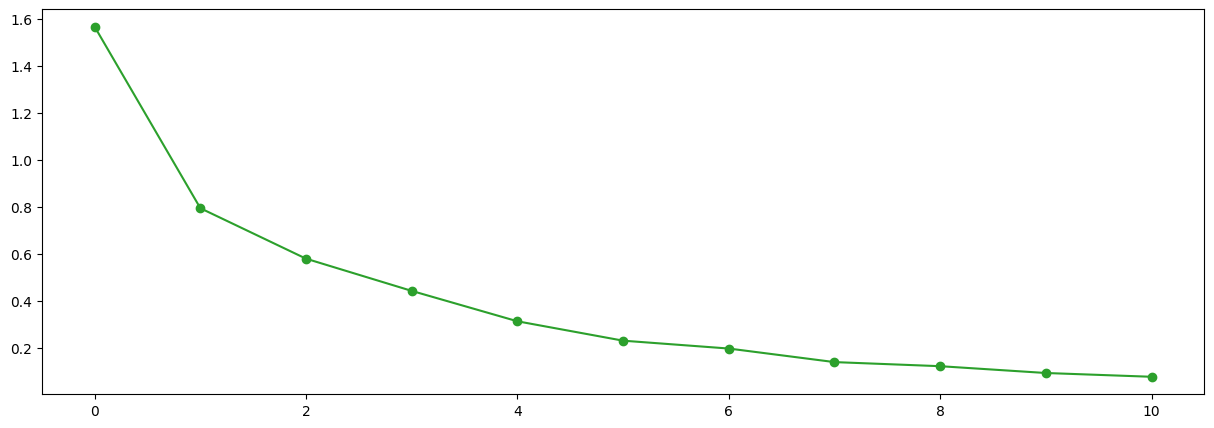

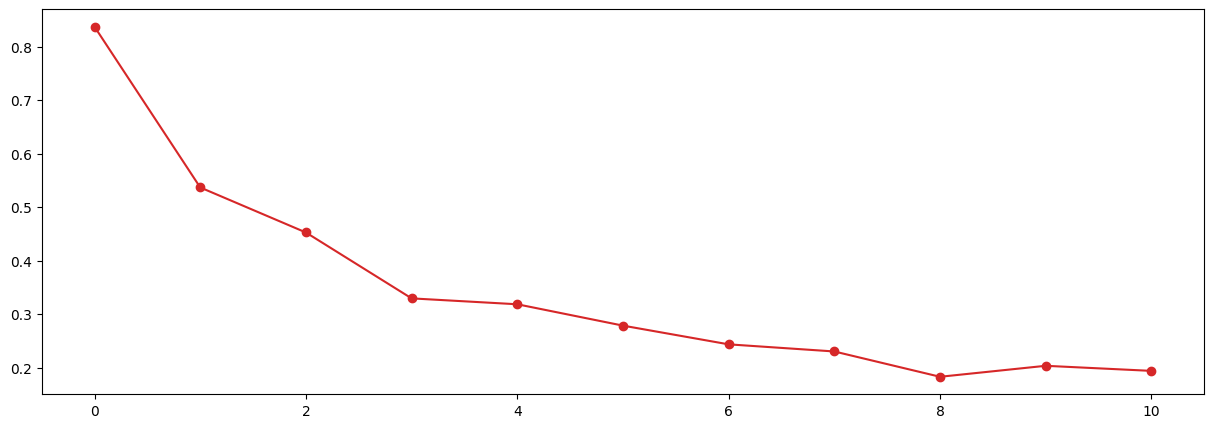

In [32]:
Epoch = 11
batch_size = 1
K.clear_session()
with strategy.scope():
    model = vgg_model(dim=160)

# TRAIN
print('Training...')
start_time = time.time()

history=model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs=Epoch,
    batch_size=32,callbacks=early_stopping_cb)
end_time = time.time()
print("Training Time: ",end_time-start_time)

# PREDICT

y_pred_proba = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # Assumes y_test is one-hot encoded or integer-encoded
print('AUC:',auc)             

Time.append(("VGG",end_time-start_time))
Auc.append(("VGG",auc))
los, accuracy, auc = model.evaluate(X_test, y_test)
loss.append(("VGG",los))

auc_values = []

# Iterate through each category (assuming one-hot encoding)
for category in range(4):  # Replace num_classes with the actual number of classes
    # Calculate the AUC for the current category
    auc = roc_auc_score(y_test[:, category], y_pred_proba[:, category])
    auc_values.append(auc)

print("AUC scores for each class:", auc_values)
Auc_classes.append(("VGG",auc_values))


# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['auc'],'-o',label='Train AUC',color='#808080')
plt.savefig('VGG_AUC.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['val_auc'],'-o',label='Val AUC',color='#000000')
plt.savefig('VGG_Val_AUC.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt.savefig('VGG_Loss.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
plt.savefig('VGG_Val_Loss.png')
plt.show()


Training...
Epoch 1/13


2023-11-15 08:09:46.862442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 66s 157ms/step - loss: 1.3292 - accuracy: 0.4113 - auc: 0.6602 - val_loss: 1.0634 - val_accuracy: 0.5918 - val_auc: 0.8101
Epoch 2/13
87/87 [==============================] - 7s 82ms/step - loss: 0.9904 - accuracy: 0.6031 - auc: 0.8312 - val_loss: 0.8160 - val_accuracy: 0.7143 - val_auc: 0.9030
Epoch 3/13
87/87 [==============================] - 7s 82ms/step - loss: 0.7905 - accuracy: 0.7022 - auc: 0.8993 - val_loss: 0.6588 - val_accuracy: 0.7857 - val_auc: 0.9386
Epoch 4/13
87/87 [==============================] - 7s 81ms/step - loss: 0.6747 - accuracy: 0.7523 - auc: 0.9271 - val_loss: 0.5688 - val_accuracy: 0.8041 - val_auc: 0.9528
Epoch 5/13
87/87 [==============================] - 7s 84ms/step - loss: 0.6037 - accuracy: 0.7794 - auc: 0.9404 - val_loss: 0.5088 - val_accuracy: 0.8286 - val_auc: 0.9610
Epoch 6/13
87/87 [==============================] - 7s 82ms/step - loss: 0.5196 - accuracy: 0.8147 - auc: 0.9561 - val_loss: 0.4621 - val_accura

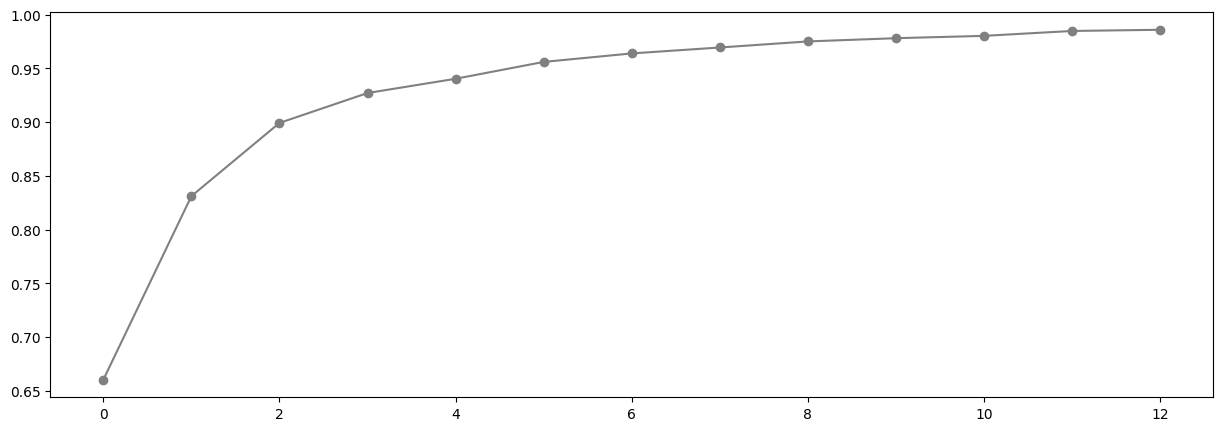

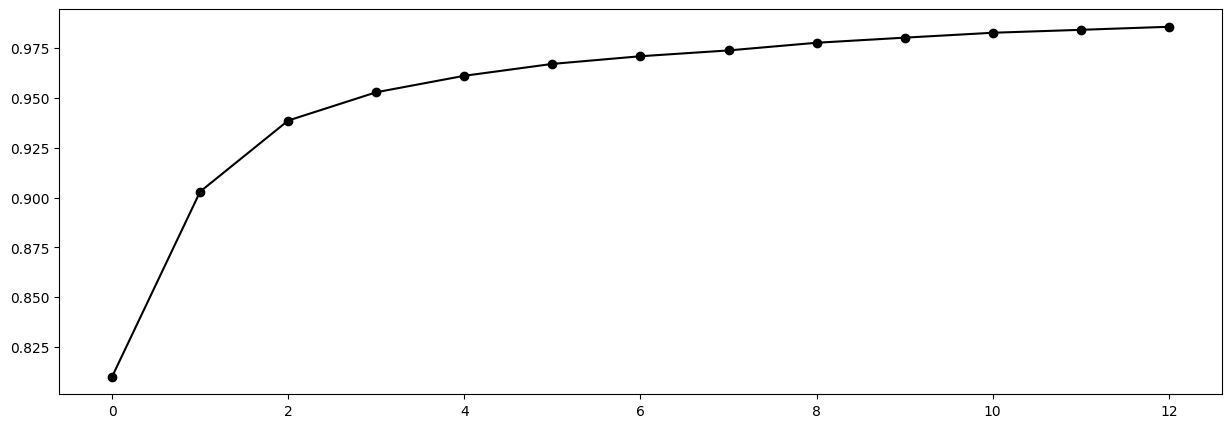

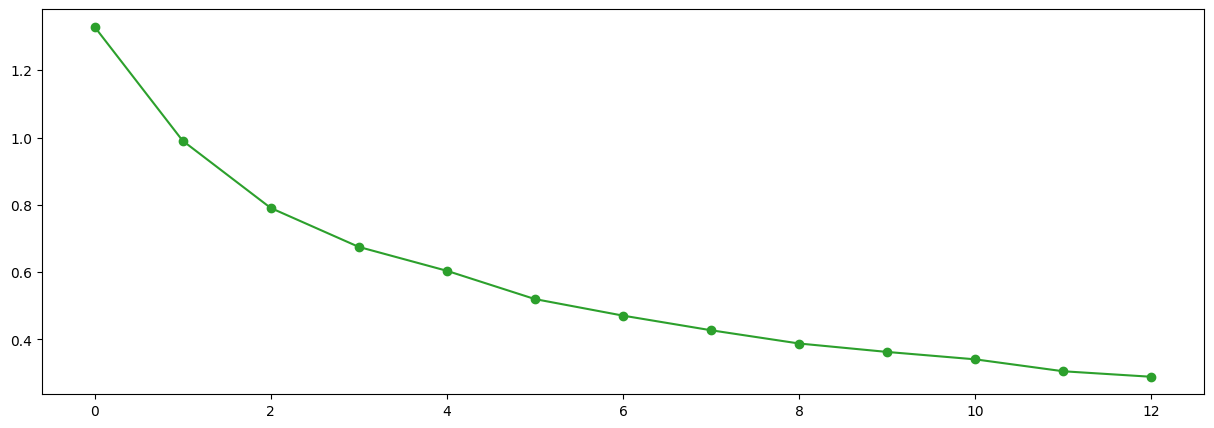

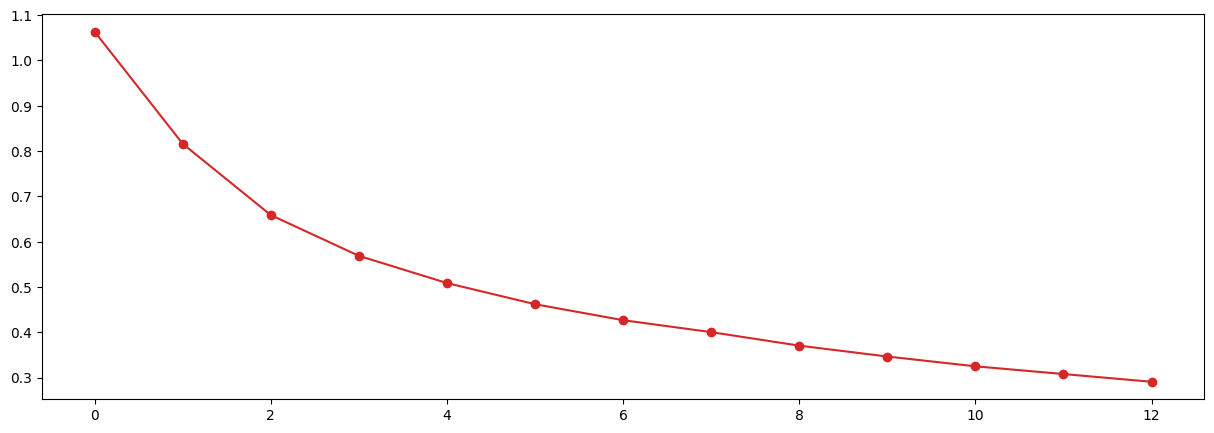

In [39]:
Epoch = 13
K.clear_session()
with strategy.scope():
    model = eff_model(dim=160)

# TRAIN
print('Training...')
start_time = time.time()

history=model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs=Epoch,
    batch_size=32,callbacks=early_stopping_cb)
end_time = time.time()
print("Training Time: ",end_time-start_time)

# PREDICT

y_pred_proba = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # Assumes y_test is one-hot encoded or integer-encoded
print('AUC:', auc)

Time.append(("eff",end_time-start_time))
Auc.append(("eff",auc))
los, accuracy,auc = model.evaluate(X_test, y_test)
loss.append(("eff",los))

auc_values = []

# Iterate through each category (assuming one-hot encoding)
for category in range(4):  # Replace num_classes with the actual number of classes
    # Calculate the AUC for the current category
    auc = roc_auc_score(y_test[:, category], y_pred_proba[:, category])
    auc_values.append(auc)

print("AUC scores for each class:", auc_values)
Auc_classes.append(("Effe",auc_values))

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['auc'],'-o',label='Train AUC',color='#808080')
plt.savefig('Effe_AUC.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['val_auc'],'-o',label='Val AUC',color='#000000')
plt.savefig('Effe_Val_AUC.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt.savefig('Effe_Loss.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
plt.savefig('Effe_Val_Loss.png')
plt.show()

94765736/94765736 [==============================] - 0s 0us/step
Training...
Epoch 1/15
87/87 [==============================] - 23s 114ms/step - loss: 1.5610 - accuracy: 0.3818 - auc: 0.6343 - val_loss: 1.0786 - val_accuracy: 0.5163 - val_auc: 0.7965
Epoch 2/15
87/87 [==============================] - 5s 58ms/step - loss: 1.0804 - accuracy: 0.5497 - auc: 0.7997 - val_loss: 0.7128 - val_accuracy: 0.7265 - val_auc: 0.9112
Epoch 3/15
87/87 [==============================] - 5s 58ms/step - loss: 0.8657 - accuracy: 0.6619 - auc: 0.8724 - val_loss: 0.5572 - val_accuracy: 0.7959 - val_auc: 0.9462
Epoch 4/15
87/87 [==============================] - 5s 59ms/step - loss: 0.7143 - accuracy: 0.7206 - auc: 0.9126 - val_loss: 0.4952 - val_accuracy: 0.8245 - val_auc: 0.9566
Epoch 5/15
87/87 [==============================] - 5s 58ms/step - loss: 0.5966 - accuracy: 0.7693 - auc: 0.9390 - val_loss: 0.4575 - val_accuracy: 0.8327 - val_auc: 0.9623
Epoch 6/15
87/87 [==============================] - 5s 6

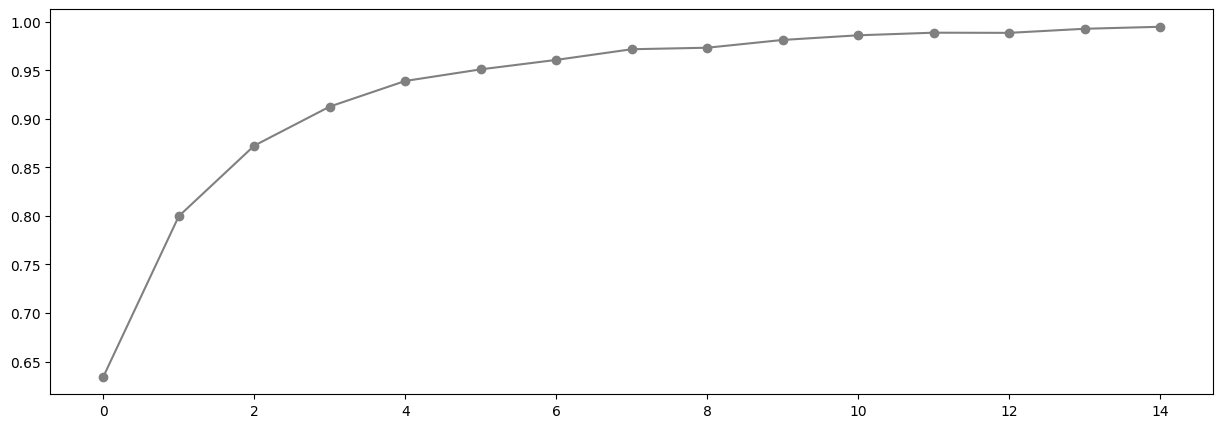

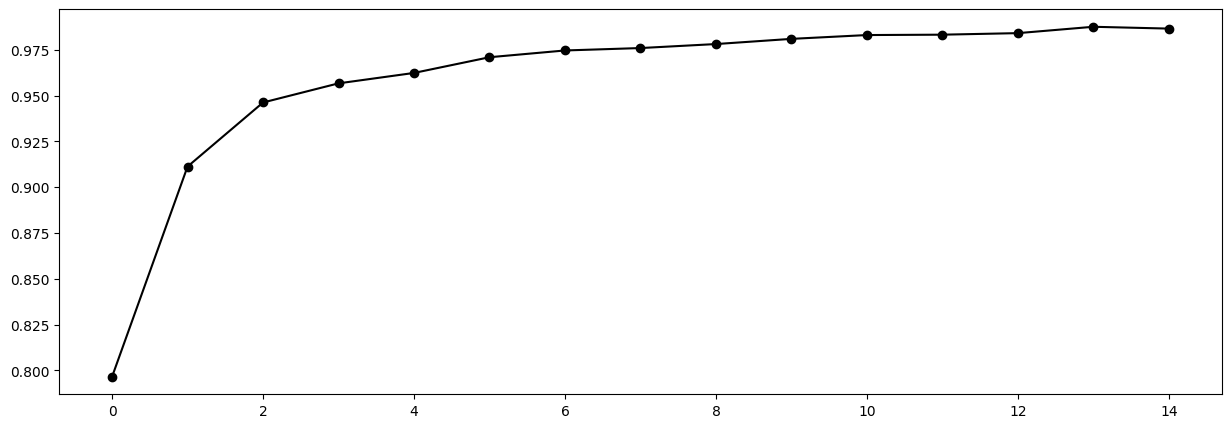

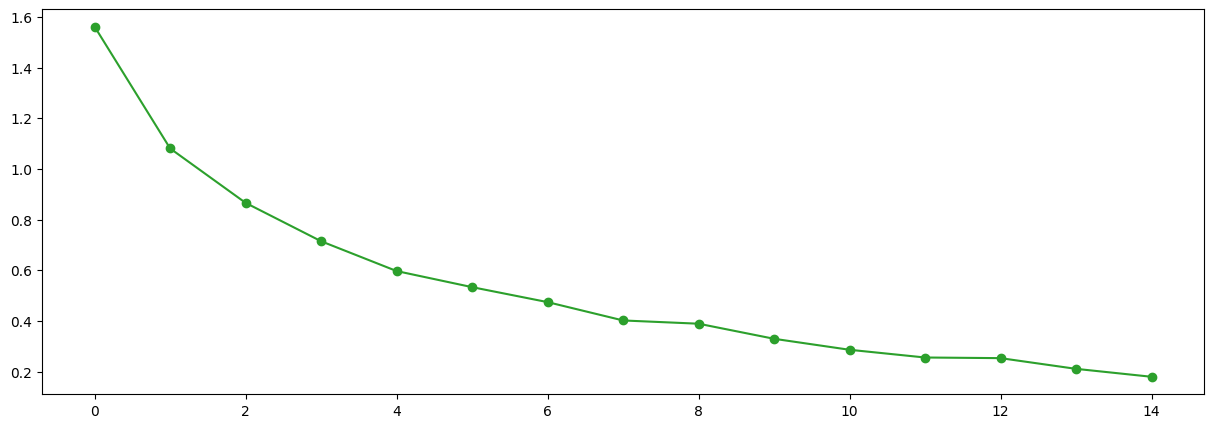

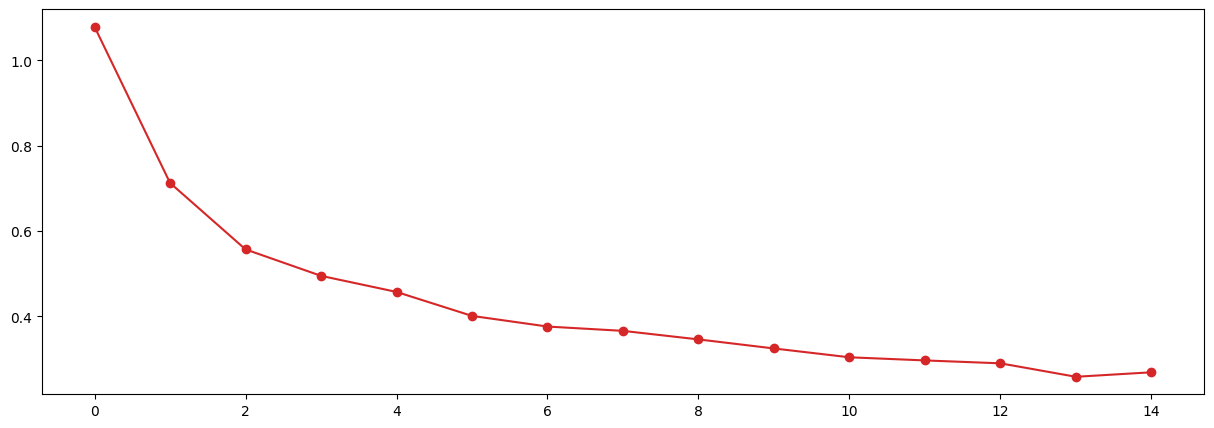

In [40]:
Epoch = 15
K.clear_session()
with strategy.scope():
    model = resnet_model(dim=160)

# TRAIN
print('Training...')
start_time = time.time()

history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=Epoch,
    batch_size=32,callbacks=early_stopping_cb)
end_time = time.time()
print("Training Time: ",end_time-start_time)

# PREDICT

y_pred_proba = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # Assumes y_test is one-hot encoded or integer-encoded
print('AUC:', auc)
             
Time.append(("Resnet",end_time-start_time))
Auc.append(("Resnet",auc))
los, accuracy,auc = model.evaluate(X_test, y_test)
loss.append(("Resnet",los))

auc_values = []

# Iterate through each category (assuming one-hot encoding)
for category in range(4):  # Replace num_classes with the actual number of classes
    # Calculate the AUC for the current category
    auc = roc_auc_score(y_test[:, category], y_pred_proba[:, category])
    auc_values.append(auc)

print("AUC scores for each class:", auc_values)
Auc_classes.append(("Resnet",auc_values))

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['auc'],'-o',label='Train AUC',color='#808080')
plt.savefig('Resnet_AUC.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['val_auc'],'-o',label='Val AUC',color='#000000')
plt.savefig('Resnet_Val_AUC.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt.savefig('Resnet_Loss.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
plt.savefig('Resnet_Val_Loss.png')
plt.show()


Training...
Epoch 1/19
87/87 [==============================] - 17s 126ms/step - loss: 4.9717 - accuracy: 0.3385 - auc: 0.5801 - val_loss: 1.3315 - val_accuracy: 0.4408 - val_auc: 0.7073
Epoch 2/19
87/87 [==============================] - 8s 93ms/step - loss: 1.4044 - accuracy: 0.3915 - auc: 0.6557 - val_loss: 1.3014 - val_accuracy: 0.4408 - val_auc: 0.7292
Epoch 3/19
87/87 [==============================] - 8s 93ms/step - loss: 1.2949 - accuracy: 0.4171 - auc: 0.6926 - val_loss: 1.2388 - val_accuracy: 0.4531 - val_auc: 0.7540
Epoch 4/19
87/87 [==============================] - 8s 93ms/step - loss: 1.2567 - accuracy: 0.4517 - auc: 0.7152 - val_loss: 1.1796 - val_accuracy: 0.5469 - val_auc: 0.7869
Epoch 5/19
87/87 [==============================] - 8s 95ms/step - loss: 1.1758 - accuracy: 0.4762 - auc: 0.7517 - val_loss: 1.1100 - val_accuracy: 0.5959 - val_auc: 0.8269
Epoch 6/19
87/87 [==============================] - 8s 90ms/step - loss: 1.1620 - accuracy: 0.4795 - auc: 0.7593 - val_lo

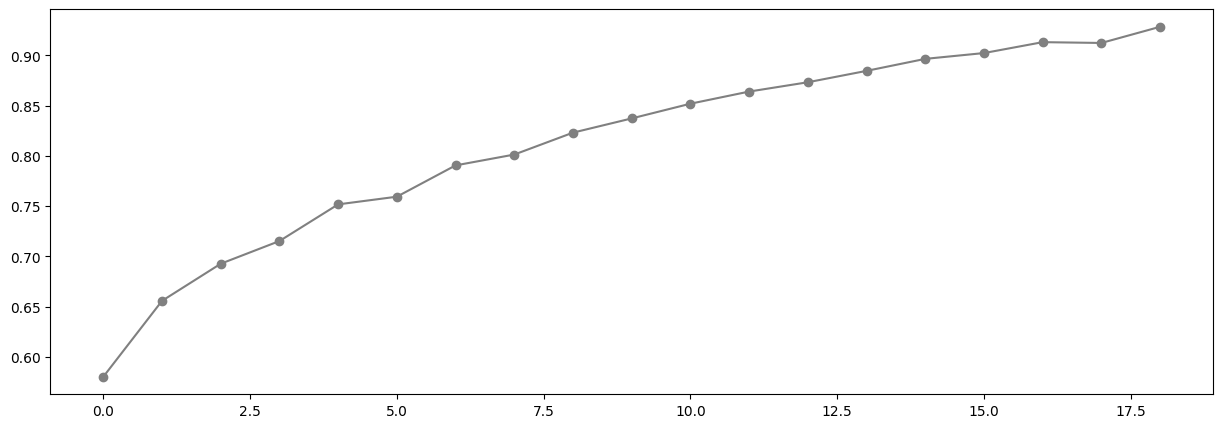

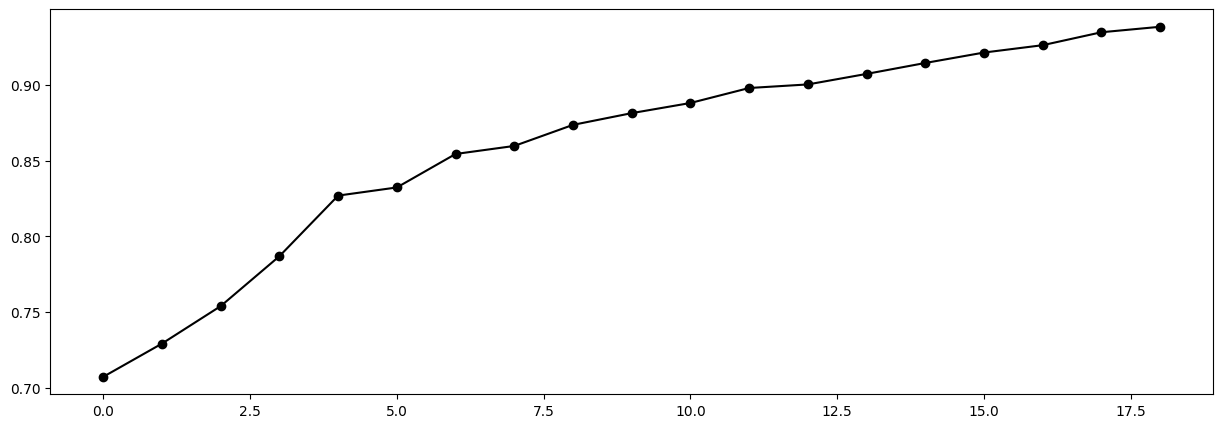

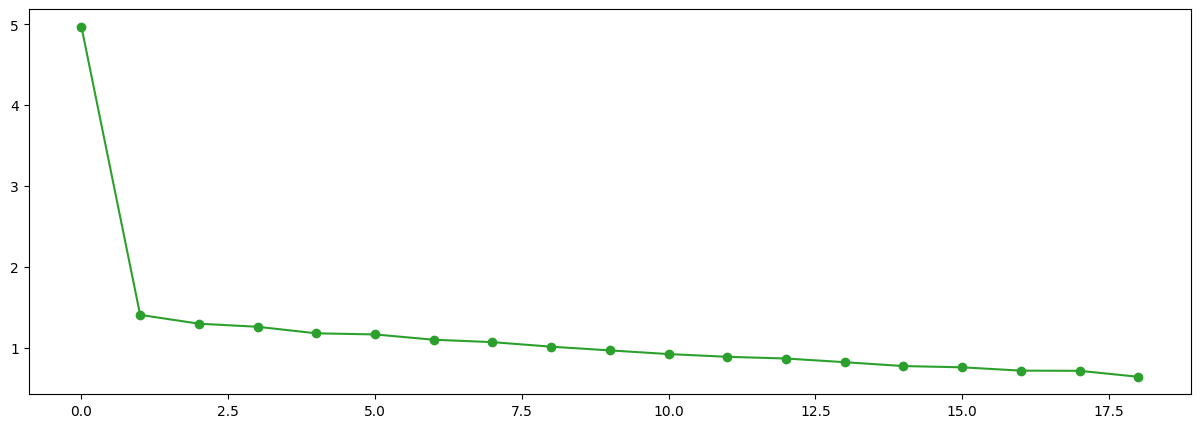

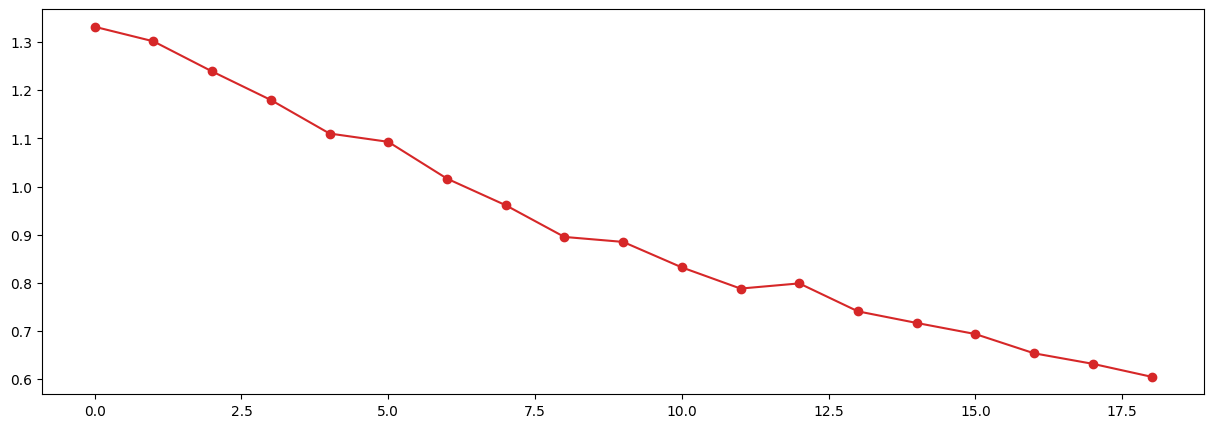

In [41]:
Epoch = 19
K.clear_session()
with strategy.scope():
    model = cnn_model(dim=160)

# TRAIN
print('Training...')
start_time = time.time()

history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=Epoch,
    batch_size=32,callbacks=early_stopping_cb)
end_time = time.time()
print("Training Time: ",end_time-start_time)

# PREDICT

y_pred_proba = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # Assumes y_test is one-hot encoded or integer-encoded
print('AUC:', auc)
             
Time.append(("CNN",end_time-start_time))
Auc.append(("CNN",auc))
los, accuracy,auc = model.evaluate(X_test, y_test)
loss.append(("CNN",los))

auc_values = []

# Iterate through each category (assuming one-hot encoding)
for category in range(4):  # Replace num_classes with the actual number of classes
    # Calculate the AUC for the current category
    auc = roc_auc_score(y_test[:, category], y_pred_proba[:, category])
    auc_values.append(auc)

print("AUC scores for each class:", auc_values)
Auc_classes.append(("CNN",auc_values))

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['auc'],'-o',label='Train AUC',color='#808080')
plt.savefig('CNN_AUC.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['val_auc'],'-o',label='Val AUC',color='#000000')
plt.savefig('CNN_Val_AUC.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt.savefig('CNN_Loss.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.arange(Epoch),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
plt.savefig('CNN_Val_Loss.png')
plt.show()


# Results trial 2

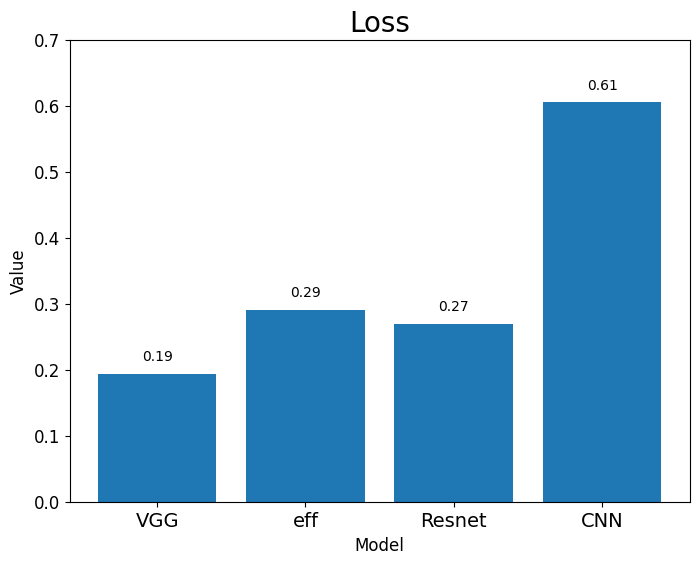

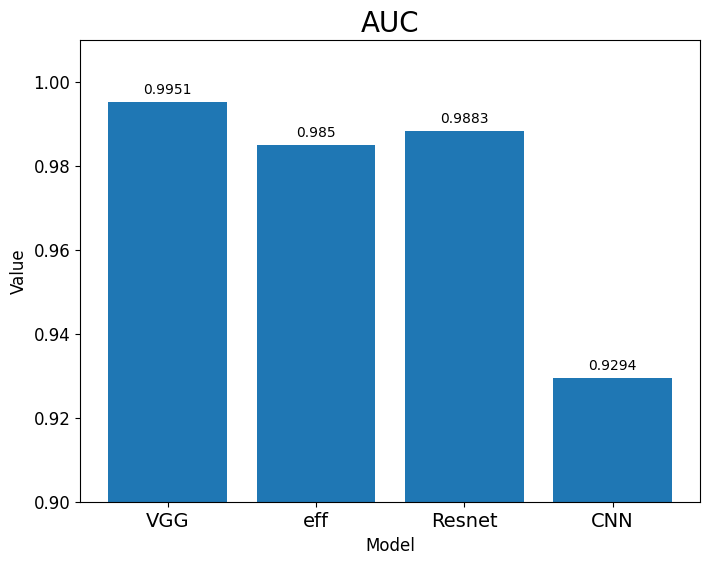

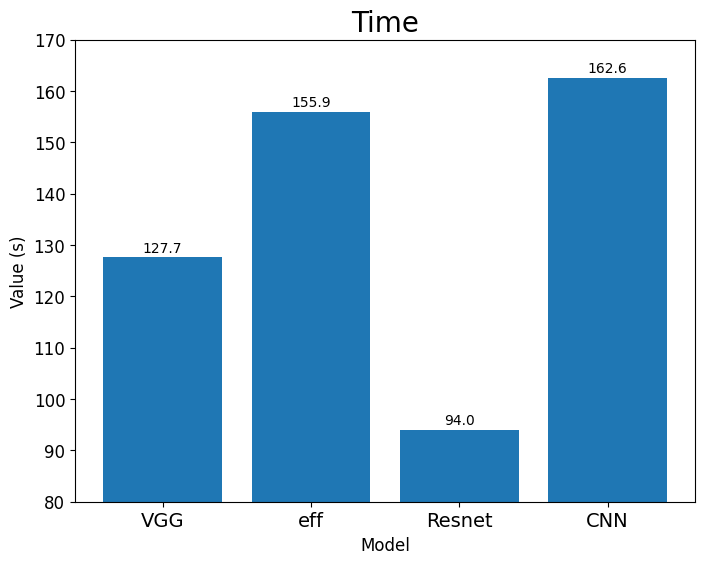

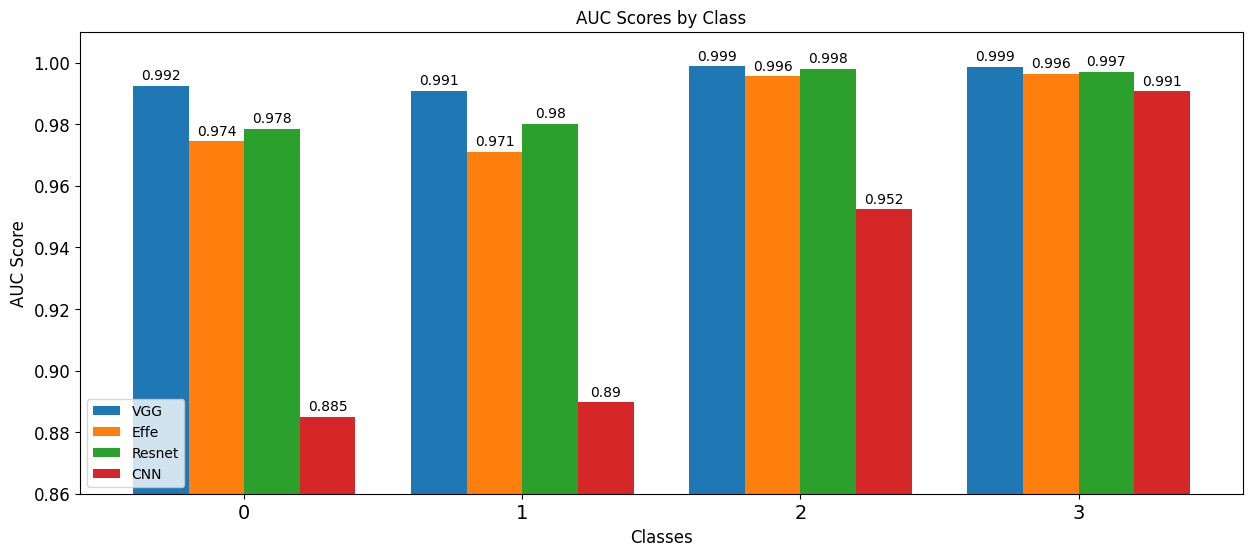

In [71]:
#Loss
plt.figure(figsize=(8, 6))
loss_names, loss_values = zip(*loss)
bars = plt.bar(loss_names, loss_values)
plt.title('Loss',fontsize=20)
plt.xlabel('Model',fontsize=12)
plt.ylabel('Value',fontsize=12)
plt.ylim(0, 0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
             str(round(bar.get_height(), 2)),
             ha='center',
            fontsize=10)

plt.savefig('Loss.png')
plt.show()

#AUC
plt.figure(figsize=(8, 6))
loss_names, loss_values = zip(*Auc)
bars = plt.bar(loss_names, loss_values)
plt.title('AUC',fontsize=20)
plt.xlabel('Model',fontsize=12)
plt.ylabel('Value',fontsize=12)
plt.ylim(0.9, 1.01)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Add values above the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.002,
             str(round(bar.get_height(), 4)),
             ha='center',
            fontsize=10)

plt.savefig('AUC.png')
plt.show()

#Time
plt.figure(figsize=(8, 6))
loss_names, loss_values = zip(*Time)
bars = plt.bar(loss_names, loss_values)
plt.title('Time',fontsize=20)
plt.xlabel('Model',fontsize=12)
plt.ylabel('Value (s)',fontsize=12)
plt.ylim(80,170)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+1,
             str(round(bar.get_height(), 1)),
             ha='center',
            fontsize=10)

plt.savefig('Time.png')
plt.show()

#AUC of each class
models, auc_scores = zip(*Auc_classes)
num_classes = len(auc_scores[0])
bar_width = 0.2
index = np.arange(num_classes)

plt.figure(figsize=(15, 6))
for i, (model, scores) in enumerate(Auc_classes):
    bars = plt.bar(index + i * bar_width, scores, bar_width, label=model)

    # Add values above the bars in the grouped bar graph
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.002, str(round(bar.get_height(), 3)), ha='center')

# Increase font size for x-axis model names
plt.xticks(index + bar_width * (len(Auc_classes) - 1) / 2, range(num_classes), fontsize=12)
plt.xlabel('Classes',fontsize=12)
plt.ylabel('AUC Score',fontsize=12)
plt.title('AUC Scores by Class')
plt.legend(loc=3)
plt.ylim(0.86,1.01)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.savefig('Auc_Classes.png')
plt.show()

# Results trial 1

In [ ]:
#Loss
plt.figure(figsize=(8, 6))
loss_names, loss_values = zip(*loss)
bars = plt.bar(loss_names, loss_values)
plt.title('Loss',fontsize=20)
plt.xlabel('Model',fontsize=12)
plt.ylabel('Value',fontsize=12)
plt.ylim(0, 5.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.05,
             str(round(bar.get_height(), 2)),
             ha='center',
            fontsize=12)

plt.show()

#AUC
plt.figure(figsize=(8, 6))
loss_names, loss_values = zip(*Auc)
bars = plt.bar(loss_names, loss_values)
plt.title('AUC',fontsize=20)
plt.xlabel('Model',fontsize=12)
plt.ylabel('Value',fontsize=12)
plt.ylim(0.9, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Add values above the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.001,
             str(round(bar.get_height(), 4)),
             ha='center',
            fontsize=12)

plt.show()

#Time
plt.figure(figsize=(8, 6))
loss_names, loss_values = zip(*Time)
bars = plt.bar(loss_names, loss_values)
plt.title('Time',fontsize=20)
plt.xlabel('Model',fontsize=12)
plt.ylabel('Value (s)',fontsize=12)
plt.ylim(80,175)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+1,
             str(round(bar.get_height(), 1)),
             ha='center',
            fontsize=12)

plt.show()

#AUC of each class
models, auc_scores = zip(*Auc_classes)
num_classes = len(auc_scores[0])
bar_width = 0.2
index = np.arange(num_classes)

plt.figure(figsize=(15, 6))
for i, (model, scores) in enumerate(Auc_classes):
    bars = plt.bar(index + i * bar_width, scores, bar_width, label=model)

    # Add values above the bars in the grouped bar graph
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.001, str(round(bar.get_height(), 3)), ha='center')

# Increase font size for x-axis model names
plt.xticks(index + bar_width * (len(Auc_classes) - 1) / 2, range(num_classes), fontsize=12)
plt.xlabel('Classes')
plt.ylabel('AUC Score')
plt.title('AUC Scores by Class')
plt.legend(loc=3)
plt.ylim(0.86,1.01)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

# Highlights

In [ ]:
# Conclusion: Transfer learning model give better results in less training time.

# Matrix used: AUC since dataset is imbalanced

# Models used: ResNet50, EfficientNetB6, VGG19(Best Result), CNN

# About Dataset: 
#     Dataset used contains MRI scan of brain of multiple peoples.  
#     Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor.

# Dataset: 
#     Train: 
#       'glioma_tumor': 787
#      'meningioma_tumor': 796
#      'no_tumor': 425
#      'pituitary_tumor': 766
#     Test: 
#       'glioma_tumor': 139
#      'meningioma_tumor': 141
#      'no_tumor': 75
#      'pituitary_tumor': 135

#Label Encoding:
#     'glioma_tumor': 0
#      'meningioma_tumor': 1
#      'no_tumor': 2
#      'pituitary_tumor': 3

# Train Data augmentation: 
# NO augmentation was done on data due to lose of AUC score after image augmentation

# Loss fn and optimiser:
# optimiser = Adam(
#         learning_rate=0.000016,
#         beta_1=0.91, 
#         beta_2=0.9994,
#         epsilon=1e-08
#         )
# loss= sparse_categorical_crossentropy

# Hardware Used: GPU T4x2